<a href="https://colab.research.google.com/github/JY522IC/PointCloudProject/blob/main/PointNetPlusGNN0725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the required library

In [ ]:
# install the required libraries
!pip install open3d
!pip install provider

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9

Import libraries

In [ ]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm
import open3d as o3d
import numpy as np

The function to acquire the labels information

In [ ]:
# input the file path and return the data of all labels
def loadData(path):
    # Load the pcd file
    pcd = o3d.io.read_point_cloud(path)

    # Control the number of points in the point cloud file
    downpcd_farthest = pcd.farthest_point_down_sample(5000)

    point_xyz = np.asarray(downpcd_farthest.points)
    color_rgb = np.asarray(downpcd_farthest.colors)

    return point_xyz,color_rgb

In [ ]:
def pc_normalize(pc):
    """
    Point data normilization
    :param pc: the pc to normilized
    :return: the point data after normilization
    """
    # the average value
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    # rescale
    pc = pc / m
    return pc

Create dataset based on pytorch geometry

In [ ]:
class Operating_room_classification(InMemoryDataset):

    # Base url to download the files
    # url = 'http://nrvis.com/download/data/labeled/FRANKENSTEIN.zip'

    def __init__(self, root, transform=None, pre_transform=None):
        super(Operating_room_classification, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # List of the raw files
        return []

    @property
    def processed_file_names(self):
        # return list of files should be in processed dir, if found - skip processing
        return ['data.pt']

    # def download(self):
    #     # Download the file specified in self.url and store
    #     # it in self.raw_dir
    #     path = download_url(self.url, self.raw_dir)
    #     extract_zip(path, self.raw_dir)
    #     # The zip file is removed
    #     os.unlink(path)


    def process(self):

      if State == 1:
        df = train_index
      else:
        df = test_index

      # In the loop we extract the nodes' embeddings, edges connectivity for
      # and label for a graph, process the information and put it in a Data
      # object, then we add the object to a list
      data_list = []
      root_new = '/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/Down20000 4'

      for index, row in df.iterrows():

        file_path = os.path.join(root_new, row[1])
        # print(file_path)
        if os.access(file_path, os.F_OK):

          # print(row[1])
          # load the data
          point_pos,color_rgb = loadData(file_path)

          # Normilize the data
          new_points = pc_normalize(point_pos)

          # Calculate the normal information
          device = o3d.core.Device("CPU:0")
          dtype = o3d.core.float64
          pcd = o3d.t.geometry.PointCloud(device)
          pcd.point.positions = o3d.core.Tensor(new_points, dtype, device)
          pcd = pcd.to_legacy()
          radius = 0.01  # Searching Radius
          max_nn = 30  # Number of neighboring points to estimate normal vector
          pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius, max_nn))

          # Convert the position and label information into the Pytorch format
          Pos = torch.tensor(new_points,dtype=torch.float32)
          Y = torch.tensor(row[2],dtype=torch.long)
          Normals = torch.tensor(np.asarray(pcd.normals),dtype=torch.float32)
          Colors = torch.tensor(color_rgb,dtype=torch.float32)

          # Save the data
          graph = Data(pos = Pos, y = Y, normal = Normals, color = Colors)
          data_list.append(graph)
        else:
          pass

        # print(index)

      # Apply the functions specified in pre_filter and pre_transform
      if self.pre_filter is not None:
          data_list = [data for data in data_list if self.pre_filter(data)]

      if self.pre_transform is not None:
          data_list = [self.pre_transform(data) for data in data_list]

      # Store the processed data
      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])

Create the dataset

In [ ]:
import torch_geometric.transforms as T
# load data
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/Two Class Down20000 4 with label.csv')
train_index=df.sample(frac=0.7)
test_index=df[~df.index.isin(train_index.index)]

In [ ]:
import torch_geometric.transforms as T

# Create the train and test dataset based on the direction
State = 1
trainDataset = Operating_room_classification(root='/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/Dataset/Train')
State = 2
testDataset = Operating_room_classification(root='/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/Dataset/Test')

## Pointnet Classification

Pointnet Layer

In [ ]:
# Pointnet layer
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels+3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.
        input = input.to(torch.float32)

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

Main Network Model

In [ ]:
from torch_geometric.nn.conv import edge_conv
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool

class PointNet(torch.nn.Module):
    def __init__(self, channel):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(channel*3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, trainDataset.num_classes)

    def forward(self, pos, batch, channel, data):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        # print(edge_index)
        # print(edge_index.shape)
        # print(edge_index.type)


        if channel == 2:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal

          # points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          # normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          new_points = np.concatenate((points,normal),axis=1)
          points = torch.Tensor(new_points)
          # points = points.transpose(2, 1)

        elif channel == 1:
          points = data.pos
          points = np.asarray(points)

          # points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          points = torch.Tensor(points)
          # points = points.transpose(2, 1)
        else:
          points = data.pos
          points = np.asarray(points)
          normal = data.normal
          color = data.color

          # points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
          # normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
          # color = np.reshape(color,[int(np.shape(normal)[0]/5000),5000,3])

          new_points = np.concatenate((points,normal,color),axis=1)
          points = torch.Tensor(new_points)
          # points = points.transpose(2, 1)

        # Start bipartite message passing.
        h = self.conv1(h=points, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # Classifier.
        return self.classifier(h)

# # Show the network structure
# model = PointNet()
# print(model)

Train and test structure

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader
import os
import sys
import torch
import numpy as np

import datetime
import logging
import provider
import importlib
import shutil
import argparse

from pathlib import Path
from tqdm import tqdm
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from sklearn.utils.class_weight import compute_sample_weight
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler

# Channel used 1: xyz, 2:xyz,normal, 3:xyz,normal,rgb
Channel = 1

# Over Sampling the data
y_label = np.asarray(trainDataset.data.y)
y_weight = compute_sample_weight(class_weight = 'balanced', y = y_label)
Sampler = WeightedRandomSampler(y_weight, len(y_label), replacement=True)

# Load the dataset using Pytorch
train_loader = DataLoader(trainDataset, batch_size=20, sampler = Sampler)
test_loader = DataLoader(testDataset, batch_size=10)

# Load the Pointnet model
model = PointNet(Channel)
# Define the optimizer type
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()

# Define the log
def log_string(str):
  logger.info(str)
  print(str)


# log_dir = '/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/LogsCoordinateCalibPointnetPlusGnn/classification/2023-05-15_15-47'
log_dir = None
model_name = 'PointNetPlusGNNWithoutCoordinateCalibration'

'''HYPER PARAMETER'''
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

'''CREATE DIR'''
timestr = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
if Channel == 1:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusGNNThreeChannel')
elif Channel ==2:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusGNNSixChannel')
else:
  exp_dir = Path('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PaperResult0725/TwoClass/PointnetPlusGNNNineChannel')

exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath('classification')
exp_dir.mkdir(exist_ok=True)

if log_dir is None:
    exp_dir = exp_dir.joinpath(timestr)
else:
    exp_dir = exp_dir.joinpath(log_dir)

exp_dir.mkdir(exist_ok=True)
checkpoints_dir = exp_dir.joinpath('checkpoints/')
checkpoints_dir.mkdir(exist_ok=True)
log_dir = exp_dir.joinpath('logs/')
log_dir.mkdir(exist_ok=True)

'''LOG'''
logger = logging.getLogger("Model")
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('%s/%s.log' % (log_dir, model_name))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
log_string('PARAMETER ...')

try:
    checkpoint = torch.load(str(exp_dir) + '/checkpoints/best_model.pth')
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    log_string('Use pretrain model')
except:
    log_string('No existing model, starting training from scratch...')
    start_epoch = 0

# Define the train part
def train(model, optimizer, loader, channel):
    model.train()

    total_loss = 0
    total_correct = 0
    for data in tqdm(loader,desc='Processing'):
      # Clear gradients.
      optimizer.zero_grad()
      # data.pos = data.pos.to(torch.float32)
      # print(data.pos.shape)
      # print(data.batch.shape)

      # Forward pass.
      logits = model(data.pos, data.batch, Channel, data)

      # Loss computation.
      loss = criterion(logits, data.y)

      # Predict Value
      pred = logits.argmax(dim=-1)
      total_correct += int((pred == data.y).sum())

      # Backward pass.
      loss.backward()

      # Update model parameters.
      optimizer.step()

      total_loss += loss.item() * data.num_graphs
      # print(total_loss)

    return total_loss / len(train_loader.dataset), total_correct / len(loader.dataset)

# Define the test part
@torch.no_grad()
def test(model, loader,channel):
    # Create the eval
    model.eval()

    total_correct = 0
    for data in loader:

      data.pos = data.pos.to(torch.float32)
      logits = model(data.pos, data.batch,channel,data)
      pred = logits.argmax(dim=-1)
      total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

best_instance_acc = 0

# Define the main part
'''TRANING'''
#logger.info('Start training...')
for epoch in range(1, 20):
    loss,train_acc = train(model, optimizer, train_loader,Channel)
    test_acc = test(model, test_loader,Channel)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}, Train Accuracy: {train_acc:.4f}')

    if (test_acc >= best_instance_acc):
      best_instance_acc = test_acc
      best_epoch = epoch + 1

    # if (class_acc >= best_class_acc):
    #     best_class_acc = class_acc
    #log_string('Train Accuracy: %f' % (train_acc))
    #log_string('Test Instance Accuracy: %f' % (test_acc))
    #log_string('Best Instance Accuracy: %f' % (best_instance_acc))

    if (test_acc >= best_instance_acc):
      # logger.info('Save model...')
      savepath = str(checkpoints_dir) + '/best_model.pth'
      # log_string('Saving at %s' % savepath)
      state = {
          'epoch': best_epoch,
          'instance_acc': test_acc,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
      }
      torch.save(state, savepath)

#logger.info('End of training...')

# Save the model
PATH = '/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PointnetPlusModel0504.pt'
torch.save(model, PATH)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:189: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
INFO:Model:PARAMETER ...
INFO:Model:No existing model, starting training from scratch...


PARAMETER ...
No existing model, starting training from scratch...


Processing: 100%|██████████| 75/75 [07:25<00:00,  5.93s/it]


Epoch: 01, Loss: 0.6432, Test Accuracy: 0.9171, Train Accuracy: 0.6013


Processing: 100%|██████████| 75/75 [07:22<00:00,  5.90s/it]


Epoch: 02, Loss: 0.2327, Test Accuracy: 0.8826, Train Accuracy: 0.9188


Processing: 100%|██████████| 75/75 [07:20<00:00,  5.88s/it]


Epoch: 03, Loss: 0.1942, Test Accuracy: 0.9609, Train Accuracy: 0.9168


Processing: 100%|██████████| 75/75 [07:23<00:00,  5.92s/it]


Epoch: 04, Loss: 0.1600, Test Accuracy: 0.9030, Train Accuracy: 0.9376


Processing: 100%|██████████| 75/75 [07:20<00:00,  5.88s/it]


Epoch: 05, Loss: 0.1507, Test Accuracy: 0.9202, Train Accuracy: 0.9450


Processing: 100%|██████████| 75/75 [07:21<00:00,  5.89s/it]


Epoch: 06, Loss: 0.1790, Test Accuracy: 0.9202, Train Accuracy: 0.9315


Processing: 100%|██████████| 75/75 [07:17<00:00,  5.83s/it]


Epoch: 07, Loss: 0.1309, Test Accuracy: 0.9703, Train Accuracy: 0.9490


Processing: 100%|██████████| 75/75 [07:16<00:00,  5.82s/it]


Epoch: 08, Loss: 0.1190, Test Accuracy: 0.9421, Train Accuracy: 0.9530


Processing: 100%|██████████| 75/75 [07:17<00:00,  5.84s/it]


Epoch: 09, Loss: 0.1019, Test Accuracy: 0.9656, Train Accuracy: 0.9604


Processing: 100%|██████████| 75/75 [07:18<00:00,  5.84s/it]


Epoch: 10, Loss: 0.0805, Test Accuracy: 0.9546, Train Accuracy: 0.9705


Processing: 100%|██████████| 75/75 [07:22<00:00,  5.90s/it]


Epoch: 11, Loss: 0.0710, Test Accuracy: 0.9687, Train Accuracy: 0.9738


Processing: 100%|██████████| 75/75 [07:24<00:00,  5.92s/it]


Epoch: 12, Loss: 0.0776, Test Accuracy: 0.9765, Train Accuracy: 0.9678


Processing: 100%|██████████| 75/75 [07:22<00:00,  5.89s/it]


Epoch: 13, Loss: 0.0972, Test Accuracy: 0.9703, Train Accuracy: 0.9638


Processing: 100%|██████████| 75/75 [07:22<00:00,  5.91s/it]


Epoch: 14, Loss: 0.0573, Test Accuracy: 0.9781, Train Accuracy: 0.9805


Processing: 100%|██████████| 75/75 [07:20<00:00,  5.88s/it]


Epoch: 15, Loss: 0.0754, Test Accuracy: 0.9765, Train Accuracy: 0.9758


Processing: 100%|██████████| 75/75 [07:24<00:00,  5.92s/it]


Epoch: 16, Loss: 0.0653, Test Accuracy: 0.9765, Train Accuracy: 0.9758


Processing: 100%|██████████| 75/75 [07:26<00:00,  5.95s/it]


Epoch: 17, Loss: 0.0729, Test Accuracy: 0.9765, Train Accuracy: 0.9738


Processing: 100%|██████████| 75/75 [07:23<00:00,  5.92s/it]


Epoch: 18, Loss: 0.0759, Test Accuracy: 0.9844, Train Accuracy: 0.9738


Processing: 100%|██████████| 75/75 [07:25<00:00,  5.94s/it]


Epoch: 19, Loss: 0.0712, Test Accuracy: 0.9718, Train Accuracy: 0.9779


https://zhuanlan.zhihu.com/p/234638980

https://medium.com/deem-blogs/speaking-code-pointnet-65b0a8ddb63f

https://github.com/yanx27/Pointnet_Pointnet2_pytorch/blob/master/models/pointnet_cls.py


# Draw the confusion matrix

Test Accuracy: 0.9828


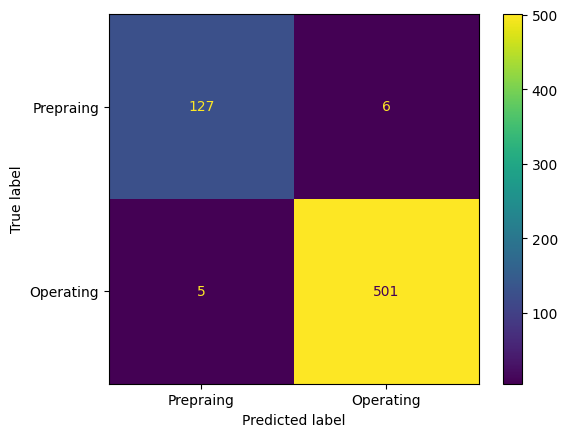

In [ ]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

use_normals = 3

# Load the test data
testDataLoader = DataLoader(testDataset, batch_size=7)


# Load the trained network parameters
model = torch.load('/content/drive/MyDrive/Colab Notebooks/Pointnet 0428/PointnetPlusModel0504.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

y_true = []
y_pred = []
total_correct = 0
with torch.no_grad():
  for data in testDataLoader:
    mean_correct = []

    if use_normals == 2:
      points = data.pos
      points = np.asarray(points)
      normal = data.normal

      points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
      normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
      new_points = np.concatenate((points,normal),axis=2)
      points = torch.Tensor(new_points)
      points = points.transpose(2, 1)

    elif use_normals == 1:
      points = data.pos
      points = np.asarray(points)

      points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
      points = torch.Tensor(points)
      points = points.transpose(2, 1)
    else:
      points = data.pos
      points = np.asarray(points)
      normal = data.normal
      color = data.color

      points = np.reshape(points,[int(np.shape(points)[0]/5000),5000,3])
      normal = np.reshape(normal,[int(np.shape(normal)[0]/5000),5000,3])
      color = np.reshape(color,[int(np.shape(color)[0]/5000),5000,3])

      new_points = np.concatenate((points,normal,color),axis=2)
      points = torch.Tensor(new_points)
      points = points.transpose(2, 1)

    logits = model(data.pos, data.batch,use_normals,data)
    pred = logits.argmax(dim=-1)
    total_correct += int((pred == data.y).sum())

    y_true.extend(data.y.numpy())
    y_pred.extend(pred.numpy())


# class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
# class_acc = np.mean(class_acc[:, 2])
instance_acc = total_correct / len(testDataLoader.dataset)


cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Prepraing','Operating'])
disp.plot()

print(f'Test Accuracy: {instance_acc:.4f}')